In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, GridSearchCV

df_rental = pd.read_csv("rental_info.csv")
df_rental.head()

df_rental['rental_date'] = pd.to_datetime(df_rental['rental_date']) 
df_rental['return_date'] = pd.to_datetime(df_rental['return_date']) 

df_rental["rental_length"] = pd.to_datetime(df_rental["return_date"]) - pd.to_datetime(df_rental["rental_date"])
df_rental["rental_length_days"] = df_rental["rental_length"].dt.days



In [2]:
df_rental["deleted_scenes"] =  np.where(df_rental["special_features"].str.contains("Deleted Scenes"), 1,0)
df_rental["behind_the_scenes"] =  np.where(df_rental["special_features"].str.contains("Behind the Scenes"), 1,0)

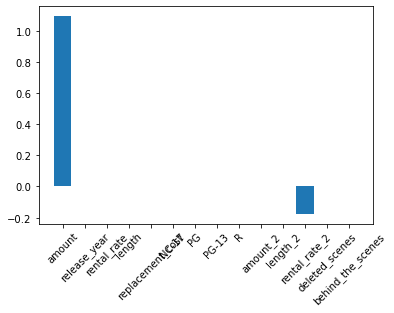

In [5]:
df_rental.columns
X = df_rental.drop(['rental_date', 'return_date', 'special_features', 'rental_length_days'], axis = 1)
y = df_rental['rental_length_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Import Lasso
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

# scores = []

# for alpha in [0.01, 0.1, 1.0, 10.0, 20.0, 50.0]:
#     # Instantiate a lasso regression model
#     lasso = Lasso(alpha = alpha)

#     # Fit the model to the data
#     lasso.fit(X_train, y_train)
#     lasso_pred = lasso.predict(X_test)
#     scores.append(lasso.score(X_test, y_test))

# print(scores)
lasso = Lasso(alpha = 0.1)
# Compute and print the coefficients
lasso_coef = lasso.fit(X, y).coef_

plt.bar(X.columns, lasso_coef)
plt.xticks(rotation=45)
plt.show()

# shows amount and rental rate are the only two significant contributing coefficients

In [8]:
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=9)
rf = RandomForestRegressor(random_state=9)

# select indicated variables
X = df_rental[['amount', 'amount_2', 'rental_rate_2']]
y = df_rental['rental_length_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# # define list containing tuples (classifier_name, classifier)
classifiers = [('Linear Regression', lr),
               ('Decision Tree', dt),
               ('Random Forest', rf)]

# Iterate over defined list of tuples
for clf_name, clf in classifiers:
    # fit clf to training set
    clf.fit(X_train, y_train)

    # predict labels
    y_pred = clf.predict(X_test)

    # evaluate accuracy of clf on test set
    print('{:s} : {:.3f}'.format(clf_name, MSE(y_test, y_pred)))


Linear Regression : 2.882
Decision Tree : 2.302
Random Forest : 2.302


In [11]:
params_rf = {
    'n_estimators': [300, 400],
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [0.3, 0.5, 1]
}

grid_rf = GridSearchCV(estimator = rf,
                       param_grid=params_rf,
                       scoring = 'neg_mean_squared_error',
                       cv = 3,
                       verbose = 1,
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)

best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

best_model = grid_rf.best_estimator_

y_pred = best_model.predict(X_test)

mse_test = MSE(y_test, y_pred)

print('Test set MSE of rf: {:.2f}'.format(mse_test))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best hyperparameters:
 {'max_depth': 6, 'min_samples_leaf': 1, 'n_estimators': 400}
Test set MSE of rf: 2.30


In [ ]:
best_model = grid_rf.best_estimator_
best_mse = mse_test